# Run tomography experiments

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from mock import MagicMock
import json

import numpy as np
from grove.tomography.state_tomography import do_state_tomography
from grove.tomography.utils import notebook_mode
from grove.tomography.process_tomography import do_process_tomography

# get fancy TQDM progress bars
notebook_mode(True)

from pyquil.gates import CZ, RY
from pyquil.api import QVMConnection, QPUConnection, get_devices
from pyquil.quil import Program

%matplotlib inline

NUM_SAMPLES = 2000

# Set this flag if you want to send programs to Forest.
SEND_PROGRAMS = True
if SEND_PROGRAMS:
    qvm = QVMConnection()
    # QPU
    online_devices = [d for d in get_devices() if d.is_online()]
    if online_devices:
        d = online_devices[0]
        qpu = QPUConnection(d.name)
        print("Found online device {}, making QPUConnection".format(d.name))
    else:
        qpu = QVMConnection()
        print("Could not find online device, defaulting to QVM")
else:
    qvm = MagicMock(QVMConnection)
    qvm.run_and_measure.side_effect = json.load(open("qvm.json", 'r'))
    qpu = MagicMock(QPUConnection)
    qpu.run_and_measure.side_effect = json.load(open("qpu.json", 'r'))

Could not find online device, defaulting to QVM


## Entangled state tomography

### Create a Bell state

In [2]:
qubits = [6, 7]
bell_state_program = Program(RY(-np.pi/2, qubits[0]),
                             RY(np.pi/2, qubits[1]),
                             CZ(qubits[0],qubits[1]),
                             RY(-np.pi/2, qubits[1]))

### Run on QPU & QVM, and calculate the fidelity

In [3]:
%%time
print("Running state tomography on the QPU...")
state_tomography_qpu, _, _ = do_state_tomography(bell_state_program, NUM_SAMPLES, qpu, qubits)
print("State tomography completed.")
print("Running state tomography on the QVM for reference...")
state_tomography_qvm, _, _ = do_state_tomography(bell_state_program, NUM_SAMPLES, qvm, qubits)
print("State tomography completed.")

Running state tomography on the QPU...


HBox(children=(IntProgress(value=0, max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=16), HTML(value=u'')))


State tomography completed.
Running state tomography on the QVM for reference...


HBox(children=(IntProgress(value=0, max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=16), HTML(value=u'')))


State tomography completed.
CPU times: user 1.18 s, sys: 84.2 ms, total: 1.27 s
Wall time: 4.6 s


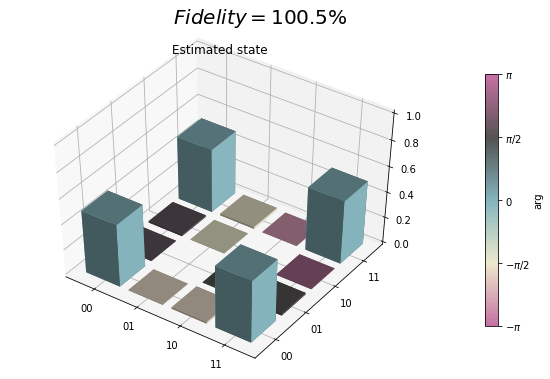

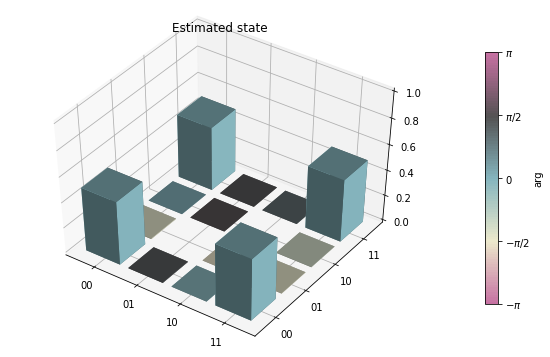

In [4]:
state_fidelity = state_tomography_qpu.fidelity(state_tomography_qvm.rho_est)

if not SEND_PROGRAMS:
    EPS = .01
    assert np.isclose(state_fidelity, 1, EPS)

qpu_plot = state_tomography_qpu.plot();
qpu_plot.text(0.35, 0.9, r'$Fidelity={:1.1f}\%$'.format(state_fidelity*100), size=20)

state_tomography_qvm.plot();

## Process tomography

### Perform process tomography on a controlled-Z (CZ) gate

In [5]:
qubits = [5, 6]
CZ_PROGRAM = Program([CZ(qubits[0], qubits[1])])
print(CZ_PROGRAM)

CZ 5 6



#### Run on the QPU & QVM, and calculate the fidelity

In [6]:
%%time
print("Running process tomography on the QPU...")
process_tomography_qpu, _, _ = do_process_tomography(CZ_PROGRAM, NUM_SAMPLES, qpu, qubits)
print("Process tomography completed.")
print("Running process tomography on the QVM for reference...")
process_tomography_qvm, _, _ = do_process_tomography(CZ_PROGRAM, NUM_SAMPLES, qvm, qubits)
print("Process tomography completed.")

Running process tomography on the QPU...


HBox(children=(IntProgress(value=0, max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=256), HTML(value=u'')))


Process tomography completed.
Running process tomography on the QVM for reference...


HBox(children=(IntProgress(value=0, max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=256), HTML(value=u'')))


Process tomography completed.
CPU times: user 16.4 s, sys: 491 ms, total: 16.8 s
Wall time: 57.4 s


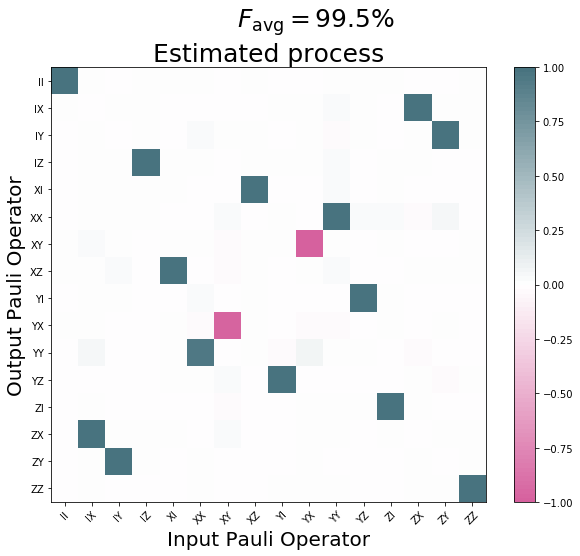

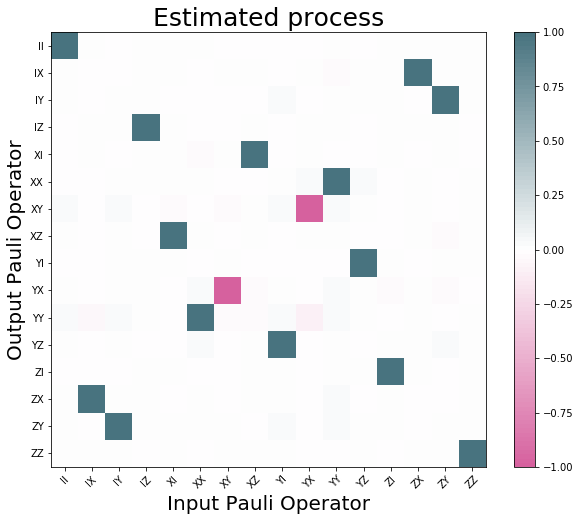

In [7]:
process_fidelity = process_tomography_qpu.avg_gate_fidelity(process_tomography_qvm.r_est)

if not SEND_PROGRAMS:
    EPS = .001
    assert np.isclose(process_fidelity, 1, EPS)

qpu_plot = process_tomography_qpu.plot();
qpu_plot.text(0.4, .95, r'$F_{{\rm avg}}={:1.1f}\%$'.format(process_fidelity*100), size=25)

process_tomography_qvm.plot();